In [1]:
import geatpy as ea
import pandas as pd
import random
import pygad
from pyswarm import pso
from scipy.optimize import differential_evolution

import math
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from pyDOE import lhs
from keras import optimizers
from numpy import concatenate
import json
import numpy as np
import geatpy as ea
import pandas as pd
import matplotlib.pyplot as plt  # 用来绘图的库
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import AdaBoostRegressor
from numpy import concatenate
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers
from sklearn.svm import SVR
from matplotlib import pyplot


import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from numpy import concatenate
import pandas as pd
import matplotlib.pyplot as plt  # 用来绘图的库
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from sklearn.ensemble import AdaBoostRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers
from sklearn.svm import SVR
import numpy as np
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
import re
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import tensorflow as tf
from tensorflow.compat.v1 import InteractiveSession
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

EA_NAME = ['soea_DE_best_1_bin_templet','soea_DE_best_1_L_templet','soea_DE_rand_1_bin_templet',
           'soea_SGA_templet','soea_EGA_templet','soea_steadyGA_templet','soea_SEGA_templet','soea_SEGA_templet']

In [2]:
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

def calcul_indicator(y, yhat):
    EV = 1 - np.var(y - yhat) / np.var(y)
    MAE = np.sum(np.abs((y - yhat))) / len(y)
    MSE = np.sum(np.multiply((y - yhat), (y - yhat))) / len(y)
    RMSE = sqrt(MSE)
    R_square = 1 - (((y - yhat) ** 2).sum()) / (((y - y.mean()) ** 2).sum())
    return [EV, MAE, MSE, RMSE, R_square]

class ArtificialImmuneNetwork:
    def __init__(self, fitness_func, num_parameters, population_size, num_generations, clone_factor, mutation_rate, suppression_threshold, early_stopping_patience):
        self.fitness_func = fitness_func
        self.num_parameters = num_parameters
        self.population_size = population_size
        self.num_generations = num_generations
        self.clone_factor = clone_factor
        self.mutation_rate = mutation_rate
        self.suppression_threshold = suppression_threshold
        self.early_stopping_patience = early_stopping_patience
        self.rmse_history = []

    def initialize_population(self):
        initial_population = lhs(self.num_parameters, samples=self.population_size)
        return initial_population

    def clone(self, population, fitness_values):
        max_fitness = np.max(fitness_values)
        min_fitness = np.min(fitness_values)
        adjusted_fitness = (max_fitness - fitness_values + 1e-10) / (max_fitness - min_fitness + 1e-10)
        clones = []
        clone_fitness_values = []
        for antibody, fitness in zip(population, adjusted_fitness):
            num_clones = max(1,int(self.clone_factor * fitness))
            clones.extend([antibody.copy() for _ in range(num_clones)])
            clone_fitness_values.extend([fitness] * num_clones)
        return np.array(clones), np.array(clone_fitness_values)

    def mutate(self, clones, clone_fitness_values):
        max_fitness = np.max(clone_fitness_values)
        min_fitness = np.min(clone_fitness_values)
        adjusted_fitness = (max_fitness - clone_fitness_values + 1e-10) / (max_fitness - min_fitness + 1e-10)
        mutation_rates = self.mutation_rate * (1 - adjusted_fitness)
        for i in range(len(clones)):
            mutation_mask = np.random.rand(self.num_parameters) < max(0.4,mutation_rates[i])
            gaussian_noise = np.random.normal(0, max(0.01,mutation_rates[i] / 4), size=self.num_parameters)
            clones[i][mutation_mask] += gaussian_noise[mutation_mask]
            clones[i] = np.clip(clones[i], 0, 1)
        return clones

    def suppress(self, antibodies, fitness_values):
        suppressed_antibodies = []
        suppressed_fitness_values = []
        for i in range(len(antibodies)):
            too_close = False
            for j in range(len(suppressed_antibodies)):
                if np.linalg.norm(antibodies[i] - suppressed_antibodies[j]) < self.suppression_threshold:
                    if fitness_values[i] < suppressed_fitness_values[j]:
                        suppressed_antibodies[j] = antibodies[i]
                        suppressed_fitness_values[j] = fitness_values[i]
                    too_close = True
                    break
            if not too_close:
                suppressed_antibodies.append(antibodies[i])
                suppressed_fitness_values.append(fitness_values[i])
        return np.array(suppressed_antibodies), np.array(suppressed_fitness_values)

    # def optimize(self):
    #     population = self.initialize_population()
    #     best_fitness = np.inf
    #     patience_counter = 0
    #     for generation in range(self.num_generations):
    #         fitness_values = np.apply_along_axis(self.fitness_func, 1, population)
    #         clones, clone_fitness_values = self.clone(population, fitness_values)
    #         mutated_clones = self.mutate(clones, clone_fitness_values)
    #         combined_population = np.vstack((population, mutated_clones))
    #         combined_fitness = np.apply_along_axis(self.fitness_func, 1, combined_population)
    #         combined_population, combined_fitness = self.suppress(combined_population, combined_fitness)
    #         best_indices = np.argsort(combined_fitness)[:self.population_size]
    #         population = combined_population[best_indices]
    #         current_best_fitness = np.min(combined_fitness)
    #         self.rmse_history.append(current_best_fitness)
    #         if current_best_fitness < best_fitness:
    #             best_fitness = current_best_fitness
    #             patience_counter = 0
    #         else:
    #             patience_counter += 1
    #             if patience_counter >= self.early_stopping_patience:
    #                 print(f"Early stopping at generation {generation}")
    #                 break
    #     best_index = np.argmin(np.apply_along_axis(self.fitness_func, 1, population))
    #     return population[best_index]
    
    def optimize(self):
        population = self.initialize_population()
        best_fitness = np.inf
        patience_counter = 0
        
        for generation in range(self.num_generations):
            fitness_values = np.apply_along_axis(self.fitness_func, 1, population)
            clones, clone_fitness_values = self.clone(population, fitness_values)
            mutated_clones = self.mutate(clones, clone_fitness_values)
            combined_population = np.vstack((population, mutated_clones))
            combined_fitness = np.apply_along_axis(self.fitness_func, 1, combined_population)
            
            suppressed_population, suppressed_fitness = self.suppress(combined_population, combined_fitness)
            
            # 如果抑制后的种群小于初始种群大小，随机生成新个体补充
            if len(suppressed_population) < self.population_size:
                num_to_add = self.population_size - len(suppressed_population)
                new_individuals = self.initialize_population()[:num_to_add]
                new_fitness = np.apply_along_axis(self.fitness_func, 1, new_individuals)
                
                suppressed_population = np.vstack((suppressed_population, new_individuals))
                suppressed_fitness = np.concatenate((suppressed_fitness, new_fitness))
            
            # 选择最佳的 population_size 个体
            best_indices = np.argsort(suppressed_fitness)[:self.population_size]
            population = suppressed_population[best_indices]
            fitness_values = suppressed_fitness[best_indices]
            
            current_best_fitness = np.min(fitness_values)
            self.rmse_history.append(current_best_fitness)
            
            if current_best_fitness < best_fitness:
                best_fitness = current_best_fitness
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= self.early_stopping_patience:
                    print(f"Early stopping at generation {generation}")
                    break
        
        best_index = np.argmin(fitness_values)
        return population[best_index]

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def RandomForest(train_X, train_y, test_X, test_y):
    model = RandomForestRegressor(n_estimators=25)
    history = model.fit(train_X, train_y)
    yhat = (history.predict(test_X)).T
    yhat = yhat.reshape(len(yhat), 1)
    test_y = test_y.reshape(len(test_y), 1)
    return calcul_indicator(test_y, yhat)

def Adaboost(train_X, train_y, test_X, test_y):
    model = AdaBoostRegressor(n_estimators=50)
    history = model.fit(train_X, train_y)
    yhat = (history.predict(test_X)).T
    yhat = yhat.reshape(len(yhat), 1)
    test_y = test_y.reshape(len(test_y), 1)
    return calcul_indicator(test_y, yhat)

def LR(train_X, train_y, test_X, test_y):
    model = Sequential()
    model.add(Dense(1, input_dim=train_X.shape[1]))
    model.compile(loss='mse', optimizer='Adam')
    history = model.fit(train_X, train_y, batch_size=60, epochs=32, validation_data=(test_X, test_y), verbose=1, shuffle=False)
    yhat = model.predict(test_X)
    yhat = yhat.reshape(len(yhat), 1)
    test_y = test_y.reshape(len(test_y), 1)
    return calcul_indicator(test_y, yhat)

def SVRR(train_X, train_y, test_X, test_y):
    model = SVR(kernel='poly')
    history = model.fit(train_X, train_y)
    yhat = (history.predict(test_X)).T
    yhat = yhat.reshape(len(yhat), 1)
    test_y = test_y.reshape(len(test_y), 1)
    return calcul_indicator(test_y, yhat)

def LSTMM(train_X, train_y, test_X, test_y):
    set_random_seed(36)
    train_X_LSTM = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X_LSTM = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    model = Sequential()
    model.add(LSTM(100, input_shape=(train_X_LSTM.shape[1], train_X_LSTM.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    learning_rate = 0.0003
    decay_rate = 0.000003
    momentum = 0.5
    sgd = optimizers.gradient_descent_v2.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    model.compile(loss='mse', optimizer=sgd)
    history = model.fit(train_X_LSTM, train_y, epochs=100, batch_size=32, validation_data=(test_X_LSTM, test_y), verbose=1, shuffle=False)
    yhat = model.predict(test_X_LSTM)
    yhat = yhat.reshape(len(yhat), 1)
    plt.cla()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('loss/val_loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()
    test_y = test_y.reshape(len(test_y), 1)
    return calcul_indicator(test_y, yhat)

# 人工免疫网络优化
def OptimizedLSTM(train_X, train_y, test_X, test_y, calcul_indicator):
    def LSTM_fitness(params):
        set_random_seed(36)
        train_X_LSTM = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X_LSTM = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        num_units = 50 + int(params[0] * 150)
        dropout_rate = params[2] * 0.5
        learning_rate = params[1] * 0.01 + 0.0001
        epochs = 30 + int(params[3] * 100)
        batch_size = 8 + int(params[4] * 120)
        model = Sequential()
        model.add(LSTM(num_units, input_shape=(train_X_LSTM.shape[1], train_X_LSTM.shape[2])))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))
        decay_rate = 0.000003
        momentum = 0.5
        sgd = optimizers.gradient_descent_v2.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
        model.compile(loss='mse', optimizer=sgd)
        history = model.fit(train_X_LSTM, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X_LSTM, test_y), verbose=1, shuffle=False)
        yhat = model.predict(test_X_LSTM)
        yhat = yhat.reshape(len(yhat), 1)
        test_y_reshaped = test_y.reshape(len(test_y), 1)
        indicators = calcul_indicator(test_y_reshaped, yhat)
        fitness = indicators[3]
        return fitness

    ain = ArtificialImmuneNetwork(LSTM_fitness, 5, 20, 30, 3, 0.8, 0.05, 5)
    best_params = ain.optimize()
    plt.plot(ain.rmse_history, label='RMSE')
    plt.xlabel('Generation')
    plt.ylabel('RMSE')
    plt.title('RMSE over Generations')
    plt.legend()
    plt.show()

    set_random_seed(36)
    best_num_units = 50 + int(best_params[0] * 150)
    best_learning_rate = best_params[1] * 0.01 + 0.0001
    best_dropout = best_params[2] * 0.5
    best_epochs = 30 + int(best_params[3] * 100)
    best_batch_size = 8 + int(best_params[4] * 120)
    train_X_LSTM = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X_LSTM = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    model = Sequential()
    model.add(LSTM(best_num_units, input_shape=(train_X_LSTM.shape[1], train_X_LSTM.shape[2])))
    model.add(Dropout(best_dropout))
    model.add(Dense(1))
    decay_rate = 0.000003
    momentum = 0.5
    sgd = optimizers.gradient_descent_v2.SGD(learning_rate=best_learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    model.compile(loss='mse', optimizer=sgd)
    history = model.fit(train_X_LSTM, train_y, epochs=best_epochs, batch_size=best_batch_size, validation_data=(test_X_LSTM, test_y), verbose=1, shuffle=False)
    yhat = model.predict(test_X_LSTM)
    yhat = yhat.reshape(len(yhat), 1)
    test_y_reshaped = test_y.reshape(len(test_y), 1)
    plt.cla()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('loss/val_loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()
    return calcul_indicator(test_y_reshaped, yhat)

# # pso优化
# lb = [0, 0, 0, 0, 0]  # 下界
# ub = [1, 1, 1, 1, 1]  # 上界

# def PSOLSTM(train_X, train_y, test_X, test_y, calcul_indicator):
#     def LSTM_fitness(params):
#         set_random_seed(38)
#         train_X_LSTM = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#         test_X_LSTM = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#         num_units = 50 + int(params[0] * 150)
#         dropout_rate = params[2] * 0.5
#         learning_rate = params[1] * 0.01 + 0.0001
#         epochs = 30 + int(params[3] * 100)
#         batch_size = 8 + int(params[4] * 120)
#         model = Sequential()
#         model.add(LSTM(num_units, input_shape=(train_X_LSTM.shape[1], train_X_LSTM.shape[2])))
#         model.add(Dropout(dropout_rate))
#         model.add(Dense(1))
#         decay_rate = 0.000003
#         momentum = 0.5
#         sgd = optimizers.gradient_descent_v2.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
#         model.compile(loss='mse', optimizer=sgd)
#         history = model.fit(train_X_LSTM, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X_LSTM, test_y), verbose=1, shuffle=False)
#         yhat = model.predict(test_X_LSTM)
#         yhat = yhat.reshape(len(yhat), 1)
#         test_y_reshaped = test_y.reshape(len(test_y), 1)
#         indicators = calcul_indicator(test_y_reshaped, yhat)
#         fitness = indicators[3]
#         return fitness
#     best_params, best_fitness = pso(LSTM_fitness, lb, ub, swarmsize=20, maxiter=30,omega=0.8, phip=0.5, phig=0.5)
#     set_random_seed(36)
#     best_num_units = 50 + int(best_params[0] * 150)
#     best_learning_rate = best_params[1] * 0.01 + 0.0001
#     best_dropout = best_params[2] * 0.5
#     best_epochs = 30 + int(best_params[3] * 100)
#     best_batch_size = 8 + int(best_params[4] * 120)
#     train_X_LSTM = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#     test_X_LSTM = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#     model = Sequential()
#     model.add(LSTM(best_num_units, input_shape=(train_X_LSTM.shape[1], train_X_LSTM.shape[2])))
#     model.add(Dropout(best_dropout))
#     model.add(Dense(1))
#     decay_rate = 0.000003
#     momentum = 0.5
#     sgd = optimizers.gradient_descent_v2.SGD(learning_rate=best_learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
#     model.compile(loss='mse', optimizer=sgd)
#     history = model.fit(train_X_LSTM, train_y, epochs=best_epochs, batch_size=best_batch_size, validation_data=(test_X_LSTM, test_y), verbose=1, shuffle=False)
#     yhat = model.predict(test_X_LSTM)
#     yhat = yhat.reshape(len(yhat), 1)
#     test_y_reshaped = test_y.reshape(len(test_y), 1)
#     plt.cla()
#     plt.plot(history.history['loss'], label='train')
#     plt.plot(history.history['val_loss'], label='test')
#     plt.ylabel('loss/val_loss')
#     plt.xlabel('Epochs')
#     plt.legend()
#     plt.show()
#     return calcul_indicator(test_y_reshaped, yhat)




# #de差分进化
# def DELSTM(train_X, train_y, test_X, test_y, calcul_indicator):
#     def LSTM_fitness(params):
#         set_random_seed(36)
#         train_X_LSTM = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#         test_X_LSTM = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#         num_units = 50 + int(params[0] * 150)
#         dropout_rate = params[2] * 0.5
#         learning_rate = params[1] * 0.01 + 0.0001
#         epochs = 30 + int(params[3] * 100)
#         batch_size = 8 + int(params[4] * 120)
#         model = Sequential()
#         model.add(LSTM(num_units, input_shape=(train_X_LSTM.shape[1], train_X_LSTM.shape[2])))
#         model.add(Dropout(dropout_rate))
#         model.add(Dense(1))
#         decay_rate = 0.000003
#         momentum = 0.5
#         sgd = optimizers.gradient_descent_v2.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
#         model.compile(loss='mse', optimizer=sgd)
#         history = model.fit(train_X_LSTM, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X_LSTM, test_y), verbose=1, shuffle=False)
#         yhat = model.predict(test_X_LSTM)
#         yhat = yhat.reshape(len(yhat), 1)
#         test_y_reshaped = test_y.reshape(len(test_y), 1)
#         indicators = calcul_indicator(test_y_reshaped, yhat)
#         fitness = indicators[3]
#         return fitness
#     class EarlyStoppingCallback:
#         def __init__(self, patience=5):
#             self.patience = patience
#             self.best_fitness = -np.inf
#             self.no_improvement_count = 0

#         def __call__(self, xk, convergence):
#             current_fitness = -LSTM_fitness(xk)  # 注意这里取负，因为SciPy默认是最小化问题
#             if current_fitness > self.best_fitness:
#                 self.best_fitness = current_fitness
#                 self.no_improvement_count = 0
#             else:
#                 self.no_improvement_count += 1

#             if self.no_improvement_count >= self.patience:
#                 return True
#             return False
#     bounds = [(0, 1)] * 5  # 5个参数，每个的范围都是0到1
#     # 创建早停回调
#     early_stopping_cb = EarlyStoppingCallback(patience=5)
#     result = differential_evolution(LSTM_fitness, bounds,callback=early_stopping_cb, maxiter=30, popsize=20)
#     best_params=result.x
#     set_random_seed(36)
#     best_num_units = 50 + int(best_params[0] * 150)
#     best_learning_rate = best_params[1] * 0.01 + 0.0001
#     best_dropout = best_params[2] * 0.5
#     best_epochs = 30 + int(best_params[3] * 100)
#     best_batch_size = 8 + int(best_params[4] * 120)
#     train_X_LSTM = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#     test_X_LSTM = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#     model = Sequential()
#     model.add(LSTM(best_num_units, input_shape=(train_X_LSTM.shape[1], train_X_LSTM.shape[2])))
#     model.add(Dropout(best_dropout))
#     model.add(Dense(1))
#     decay_rate = 0.000003
#     momentum = 0.5
#     sgd = optimizers.gradient_descent_v2.SGD(learning_rate=best_learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
#     model.compile(loss='mse', optimizer=sgd)
#     history = model.fit(train_X_LSTM, train_y, epochs=best_epochs, batch_size=best_batch_size, validation_data=(test_X_LSTM, test_y), verbose=1, shuffle=False)
#     yhat = model.predict(test_X_LSTM)
#     yhat = yhat.reshape(len(yhat), 1)
#     test_y_reshaped = test_y.reshape(len(test_y), 1)
#     plt.cla()
#     plt.plot(history.history['loss'], label='train')
#     plt.plot(history.history['val_loss'], label='test')
#     plt.ylabel('loss/val_loss')
#     plt.xlabel('Epochs')
#     plt.legend()
#     plt.show()
#     return calcul_indicator(test_y_reshaped, yhat)


C:\Users\han\AppData\Local\Temp\ipykernel_22952\1843830253.py:41: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = RandomForest(train_X,train_y,test_X,test_y)
C:\Users\han\AppData\Local\Temp\ipykernel_22952\1843830253.py:43: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = Adaboost(train_X,train_y,test_X,test_y)


Epoch 1/32
11/11 [==============================] - 0s 9ms/step - loss: 0.1173 - val_loss: 0.1130
Epoch 2/32
11/11 [==============================] - 0s 2ms/step - loss: 0.0851 - val_loss: 0.0843
Epoch 3/32
11/11 [==============================] - 0s 2ms/step - loss: 0.0685 - val_loss: 0.0687
Epoch 4/32
11/11 [==============================] - 0s 2ms/step - loss: 0.0582 - val_loss: 0.0595
Epoch 5/32
11/11 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0533
Epoch 6/32
11/11 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0488
Epoch 7/32
11/11 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0454
Epoch 8/32
11/11 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0427
Epoch 9/32
11/11 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0406
Epoch 10/32
11/11 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0390
Epoch 11/32
11/11 [

C:\Users\han\AppData\Local\Temp\ipykernel_22952\1843830253.py:45: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = LR(train_X,train_y,test_X,test_y)
C:\Users\han\AppData\Local\Temp\ipykernel_22952\1843830253.py:47: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = SVRR(train_X,train_y,test_X,test_y)


21/21 [==============================] - 1s 9ms/step - loss: 0.0468 - val_loss: 0.0596
Epoch 2/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0577
Epoch 3/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0560
Epoch 4/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0544
Epoch 5/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0529
Epoch 6/100
21/21 [==============================] - 0s 1ms/step - loss: 0.0399 - val_loss: 0.0515
Epoch 7/100
21/21 [==============================] - 0s 1ms/step - loss: 0.0382 - val_loss: 0.0502
Epoch 8/100
21/21 [==============================] - 0s 1ms/step - loss: 0.0370 - val_loss: 0.0490
Epoch 9/100
21/21 [==============================] - 0s 1ms/step - loss: 0.0366 - val_loss: 0.0479
Epoch 10/100
21/21 [==============================] - 0s 1ms/step - loss: 0.0353 - val_loss: 0.0469
Epoch 11/100
21/21 [=

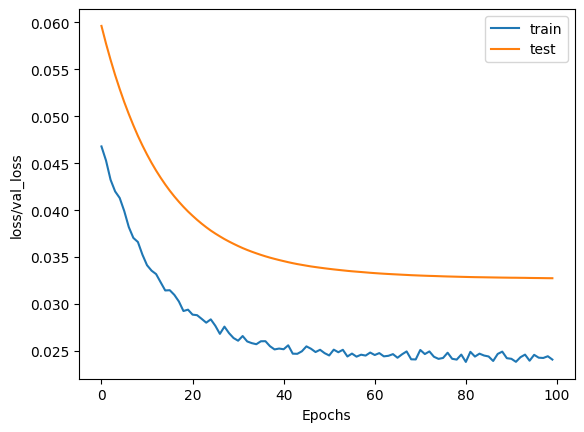

C:\Users\han\AppData\Local\Temp\ipykernel_22952\1843830253.py:49: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = LSTMM(train_X,train_y,test_X,test_y)


Epoch 1/100
21/21 [==============================] - 1s 10ms/step - loss: 0.0460 - val_loss: 0.0588
Epoch 2/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0573
Epoch 3/100
21/21 [==============================] - 0s 1ms/step - loss: 0.0434 - val_loss: 0.0560
Epoch 4/100
21/21 [==============================] - 0s 1ms/step - loss: 0.0420 - val_loss: 0.0547
Epoch 5/100
21/21 [==============================] - 0s 1ms/step - loss: 0.0411 - val_loss: 0.0535
Epoch 6/100
21/21 [==============================] - 0s 1ms/step - loss: 0.0403 - val_loss: 0.0523
Epoch 7/100
21/21 [==============================] - 0s 1ms/step - loss: 0.0393 - val_loss: 0.0512
Epoch 8/100
21/21 [==============================] - 0s 1ms/step - loss: 0.0381 - val_loss: 0.0502
Epoch 9/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0492
Epoch 10/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0483
Epoch 11

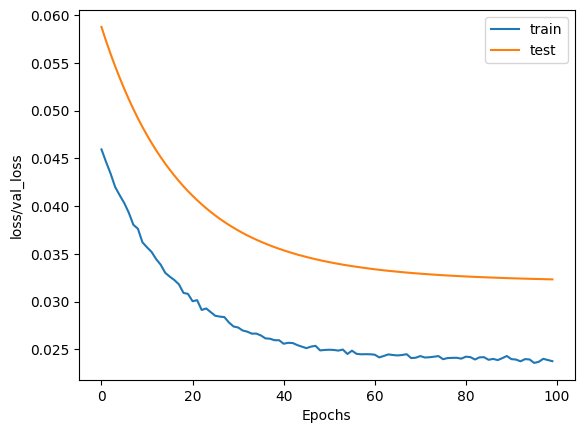

C:\Users\han\AppData\Local\Temp\ipykernel_22952\1843830253.py:49: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = LSTMM(train_X,train_y,test_X,test_y)


Epoch 1/72
25/25 [==============================] - 1s 9ms/step - loss: 0.0368 - val_loss: 0.0414
Epoch 2/72
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0354
Epoch 3/72
25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0333
Epoch 4/72
25/25 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0326
Epoch 5/72
25/25 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0323
Epoch 6/72
25/25 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0322
Epoch 7/72
25/25 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0321
Epoch 8/72
25/25 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0321
Epoch 9/72
25/25 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0321
Epoch 10/72
25/25 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0321
Epoch 11/72
25/25 [

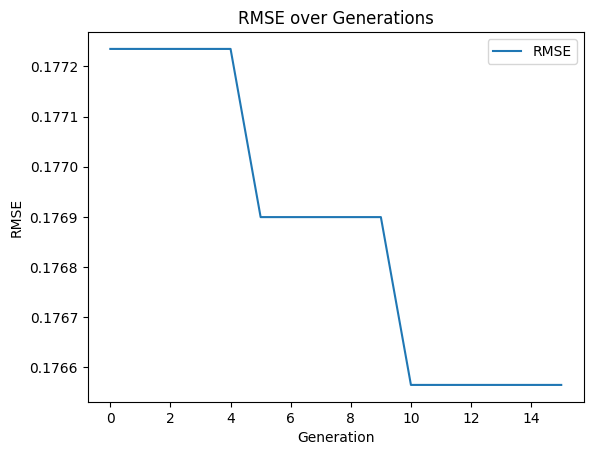

Epoch 1/79
9/9 [==============================] - 1s 22ms/step - loss: 0.0620 - val_loss: 0.0606
Epoch 2/79
9/9 [==============================] - 0s 4ms/step - loss: 0.0431 - val_loss: 0.0465
Epoch 3/79
9/9 [==============================] - 0s 6ms/step - loss: 0.0333 - val_loss: 0.0392
Epoch 4/79
9/9 [==============================] - 0s 5ms/step - loss: 0.0281 - val_loss: 0.0355
Epoch 5/79
9/9 [==============================] - 0s 4ms/step - loss: 0.0260 - val_loss: 0.0335
Epoch 6/79
9/9 [==============================] - 0s 4ms/step - loss: 0.0255 - val_loss: 0.0325
Epoch 7/79
9/9 [==============================] - 0s 4ms/step - loss: 0.0247 - val_loss: 0.0319
Epoch 8/79
9/9 [==============================] - 0s 3ms/step - loss: 0.0243 - val_loss: 0.0316
Epoch 9/79
9/9 [==============================] - 0s 4ms/step - loss: 0.0243 - val_loss: 0.0314
Epoch 10/79
9/9 [==============================] - 0s 4ms/step - loss: 0.0242 - val_loss: 0.0313
Epoch 11/79
9/9 [=====================

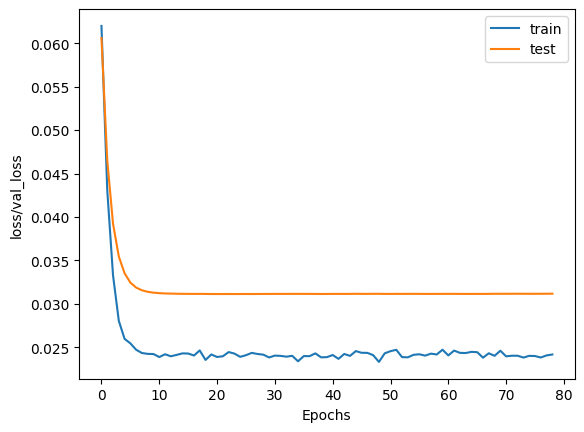

C:\Users\han\AppData\Local\Temp\ipykernel_22952\1843830253.py:58: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method]=indicators


In [3]:
if __name__ == '__main__':
    areas = ['DS1']
    indicator = ['EV','MAE','MSE','RMSE','R_square']

    # 如果是需要改动对比的算法，在这里进行改进即可
    classifers = ['RF','Adaboost','LinearRegression','SVR','LSTM','SEGA-LSTM','SEGA-ImmuneNetwork']
    df = pd.DataFrame(columns=classifers, index=indicator)
    #df = pd.DataFrame()
    for area in areas:
        path = './{}/'.format(area)
        pre_data_df = pd.read_csv(path+'8area_{}.csv'.format(area))
        # 对每种方法进行遍历
        for method in classifers:
            data_df  =pre_data_df
            if method[:4]=='SEGA':
                res = pd.read_csv(path+'soea_SEGA_templet/optPop/Chrom.csv',header=None)
                values = res.values
                features = data_df.columns[1:]
                best_features = []
                best_features.append('label_M')
                for index in range(values.shape[1]):
                     if values[0][index] == 1:#筛选出来的特征，如果是1则选上，如果是0，则不选。
                         best_features.append(features[index])
                data_df = data_df[best_features]
            values = data_df.values
            values = values.astype('float32')
            #进行标准化的操作
            scaler = MinMaxScaler(feature_range = (0,1))
            scaled = scaler.fit_transform(values)
            reframed = series_to_supervised(scaled,1,1)
            reframed.drop(reframed.columns[[i for i in range(int(reframed.shape[1] / 2) + 1, reframed.shape[1])]], axis=1,inplace=True)

            #split into input
            values = reframed.values
            n_train_hours = int(reframed.shape[0]*0.7)
            train = values[:n_train_hours:]
            test = values[n_train_hours:,:]
            train_X, train_y = train[:, 1:], train[:, 0]  # 训练集特征和目标
            test_X, test_y = test[:, 1:], test[:, 0]  # 测试集特征和目标
            if re.search('RF', method):
                df.loc[:,method] = RandomForest(train_X,train_y,test_X,test_y)
            elif re.search('Adaboost',method):
                df.loc[:,method] = Adaboost(train_X,train_y,test_X,test_y)
            elif re.search('LinearRegression',method):
                df.loc[:,method] = LR(train_X,train_y,test_X,test_y)
            elif re.search('SVR', method):
                df.loc[:,method] = SVRR(train_X,train_y,test_X,test_y)
            elif re.search('LSTM', method):
                df.loc[:,method] = LSTMM(train_X,train_y,test_X,test_y)
            # elif re.search('DE', method):
            #     indicators = DELSTM(train_X,train_y,test_X,test_y,calcul_indicator)
            #     df.loc[:,method]=indicators   
            # elif re.search('PSO', method):
            #     indicators = PSOLSTM(train_X,train_y,test_X,test_y,calcul_indicator)
            #     df.loc[:,method]=indicators
            elif re.search('ImmuneNetwork', method):
                indicators = OptimizedLSTM(train_X, train_y, test_X, test_y, calcul_indicator)
                df.loc[:,method]=indicators
        df.to_csv(path+'comparision_methodsmemory_{}.csv'.format(area))